<a href="https://www.kaggle.com/code/ksetdekov/coffee-amount-optimization?scriptVersionId=218555441" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Ноутбук для подбора количества кофе, которое минимизирует стресс

## main class

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gamma, norm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import plotly.express as px

class HandsTable():
    minimize = True
    rho = 3.37

    def __init__(self, options_list, minimize=True, rho=1.0):
        """инициализация

        Args:
            options_list (list): список из названий
            minimize (bool, optional): Минимизировать если True, максимизировать если False. Defaults to True.
            rho (float, optional): Риск толерантность, чем больше, тем больше риска готовы принять. Defaults to 1.0.
        """
        self.hands = pd.DataFrame({'name': options_list,
                                   'mu': 0.0,
                                   'Te': 0.0,
                                   'alpha': 0.5,
                                   'beta': 0.5
                                   })
        self.minimize = minimize
        if rho is not None:
            self.rho = rho

        self.history = pd.DataFrame(columns=['option', 'value'])

    @classmethod
    def to_minutes(self, timestr: str):
        '''
        convert timestr to float minutes
        '''
        return pd.to_timedelta(timestr).total_seconds()/60

    @classmethod
    def update_mean(self, X, T_last, mu_last):
        mu_new = T_last * mu_last / (T_last + 1) + X / (T_last + 1)
        return mu_new

    @classmethod
    def update_samples(self, T):
        return T + 1

    @classmethod
    def update_shape(self, a):
        return a + 0.5

    @classmethod
    def update_rate(self, X, mu_last, beta_last, T_last):
        beta_new = beta_last + (T_last / (T_last + 1)) * \
            (np.square(X - mu_last)) / 2
        return beta_new

    def update_hands(self, name, value):
        if isinstance(value, str):
            try:
                value = HandsTable.to_minutes(value)
            except ValueError:
                raise ValueError('input time string in hh:mm:ss format')
        elif isinstance(value, float) or isinstance(value, int):
            pass
        else:
            raise ValueError('input time string or int/float value')

        _, mu, t, alpha, beta = self.hands[self.hands.name == name].values[0]
        beta = HandsTable.update_rate(value, mu, beta, t)
        mu = HandsTable.update_mean(value, t, mu)
        t = HandsTable.update_samples(t)
        alpha = HandsTable.update_shape(alpha)

        # added code to write history
        self.history.loc[len(self.history.index)] = [name, value]

        self.hands.loc[self.hands.name == name, 'mu'] = mu
        self.hands.loc[self.hands.name == name, 'Te'] = t
        self.hands.loc[self.hands.name == name, 'alpha'] = alpha
        self.hands.loc[self.hands.name == name, 'beta'] = beta

    def grade(self):
        hands_output = self.hands.copy()
        tau = gamma.rvs(a=hands_output.alpha, scale=1/hands_output.beta)
        theta_drops = norm.rvs(hands_output.mu, 1/hands_output.Te)
        hands_output['tau'] = tau
        hands_output['theta'] = theta_drops
        hands_output['SD'] = np.sqrt(1/tau)

        if self.minimize == True:
            hands_output['var95'] = theta_drops + \
                norm.ppf(1-0.05/2) * hands_output.SD
            if hands_output.mu.min() == 0:

                output_df = hands_output.reindex(np.argsort(hands_output.Te))
            else:
                output_df = hands_output.reindex(
                    np.argsort(self.rho * theta_drops + 1/tau))
        else:
            hands_output['var95'] = theta_drops + \
                norm.ppf(0.05/2) * hands_output.SD
            if hands_output.mu.min() == 0:
                output_df = hands_output.reindex(np.argsort(hands_output.Te))
            else:
                output_df = hands_output.reindex(
                    np.argsort(self.rho * theta_drops - 1/tau)[::-1])

        return output_df

    def __str__(self):
        return repr(self.hands)

# Применение

In [2]:
cups = HandsTable(options_list=[*range(4+1)], minimize=True, rho=5)
# cups.update_hands(0, 32) # суббота 9 ноября
# cups.update_hands(2, 33) # воскресенье 10 ноября
# cups.update_hands(1, 35) # вторник 12 ноября
# cups.update_hands(3, 34) # среда 13 ноября
# cups.update_hands(4, 34) # четверг 14 ноября
# cups.update_hands(3, 34) # пятница 15 ноября
# cups.update_hands(1, 34) # суббота 16 ноября
# cups.update_hands(1, 43) # воскресенье 17 ноября
# # cups.update_hands(6, 28) # понедельник 18 ноября я убрал 5  и 6 из подбора, это мучительно
# # cups.update_hands(5, 39) # вторник 19 ноября
# cups.update_hands(4, 38) # wednesday 20 ноября
# cups.update_hands(0, 36) # thursday 21 ноября
# cups.update_hands(2, 33) # friday 22 ноября
# cups.update_hands(0, 37) # sat 23 ноября
# cups.update_hands(1, 32) # sun 24 ноября
# cups.update_hands(2, 28) # mon 25 ноября
# cups.update_hands(3, 29) # tue 26 ноября
# cups.update_hands(3, 25) # wed 27 ноября
# cups.update_hands(2, 30) # th 28 ноября
# cups.update_hands(2, 29) # fr 29 ноября
# cups.update_hands(2, 29) # sat 30 ноября
# cups.update_hands(2, 33) # sun 1 dec
# cups.update_hands(2, 24) # mon 2 dec
# cups.update_hands(2, 25) # tue 3 dec
# cups.update_hands(3, 25) # wed 4 dec
# cups.update_hands(3, 29) # th 5 dec
# cups.update_hands(1, 31) # fr 6 dec
# cups.update_hands(0, 35) # sat 7 dec
# cups.update_hands(0, 25) # sun 8 dec
# cups.update_hands(2, 25) # mon 9 dec
# cups.update_hands(3, 34) # tue 10 dec
# cups.update_hands(2, 34) # wed 11 dec
# cups.update_hands(2, 33) # th 12 dec
# cups.update_hands(2, 28) # пт 13 dec
# cups.update_hands(2, 37) # сб 14 dec
# cups.update_hands(2, 32) # вс 15 dec
# cups.update_hands(3, 32) # mon 16 dec
# cups.update_hands(3, 27) # tue 17 dec
# cups.update_hands(3, 28) # wed 18 dec
# cups.update_hands(3, 28) # th 19 dec
# cups.update_hands(3, 30) # fr 20 dec
# cups.update_hands(3, 44) # sat 21 dec
# cups.update_hands(2, 29) # sun 22 dec
# cups.update_hands(2, 31) # mon 23 dec
# cups.update_hands(2, 34) # tue 24 dec
# cups.update_hands(2, 32) # wed 25 dec
# cups.update_hands(4, 22) # thr 26 dec
# cups.update_hands(4, 30) # fr 27 dec
cups.update_hands(2, 37) # sat 28 dec !
cups.update_hands(1, 29) # sun 29 dec !
cups.update_hands(2, 23) # mon 30 dec !
cups.update_hands(2, 26) # tue 31 dec !
cups.update_hands(2, 29) # wed 1 jan !
cups.update_hands(2, 26) # thr 2 jan !
cups.update_hands(0, 28) # fr 3 jan !
cups.update_hands(3, 27) # sat 4 jan !
cups.update_hands(4, 25) # sun 5 jan !
cups.update_hands(2, 35) # mon 6 jan !
cups.update_hands(3, 29) # tue 7 jan !
cups.update_hands(4, 37) # wed 8 jan !
cups.update_hands(3, 20) # thr 9 jan !
cups.update_hands(3, 27) # fr 10 jan !
cups.update_hands(1, 41) # sat 11 jan !
cups.update_hands(3, 32) # sun 12 jan !
cups.update_hands(3, 22) # mon 13 jan !
cups.update_hands(4, 21) # tue 14 jan !
cups.update_hands(3, 38) # wed 15 jan !
cups.update_hands(0, 33) # thr 16 jan !
cups.update_hands(3, 27) # fr 17 jan !
cups.update_hands(0, 39) # sat 18 jan !
cups.update_hands(2, 27) # sun 19 jan !
cups.update_hands(2, 32) # mon 20 jan !

cups.grade()

,name,mu,Te,alpha,beta,tau,theta,SD,var95
2,2,29.375000,8.0,4.5,83.437500,0.050520,29.350064,4.449072,38.070085
4,4,27.666667,3.0,2.0,69.833333,0.027871,28.013126,5.989981,39.753273
0,0,33.333333,3.0,2.0,30.833333,0.064244,33.517273,3.945326,41.249970
1,1,35.000000,2.0,1.5,36.500000,0.125549,35.672756,2.822231,41.204227
3,3,27.750000,8.0,4.5,110.250000,0.014659,27.578152,8.259511,43.766496


100%|██████████| 10000/10000 [00:26<00:00, 375.58it/s]


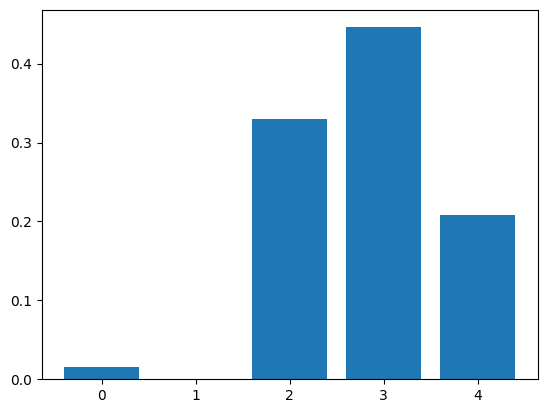

,variant,prob
3,0,0.0152
4,1,0.0006
0,2,0.3304
1,3,0.4460
2,4,0.2078


In [3]:

results = defaultdict(int)
for i in tqdm(range(10000)):
    i_res = cups.grade()
    i_var = int(i_res.iloc[0]['name'])
    results[i_var] += 1

variants_proba_current = pd.DataFrame(results.items(), columns=['variant', 'prob'])
variants_proba_current['prob'] = variants_proba_current['prob']/sum(variants_proba_current['prob'])
variants_proba_current = variants_proba_current.sort_values('variant')

plt.bar(variants_proba_current['variant'], variants_proba_current['prob'], align='center')

plt.show()
variants_proba_current

In [4]:

fig = px.violin(cups.history, y="value", x="option", box=True, points="all",
          hover_data=cups.history.columns)
fig.show()

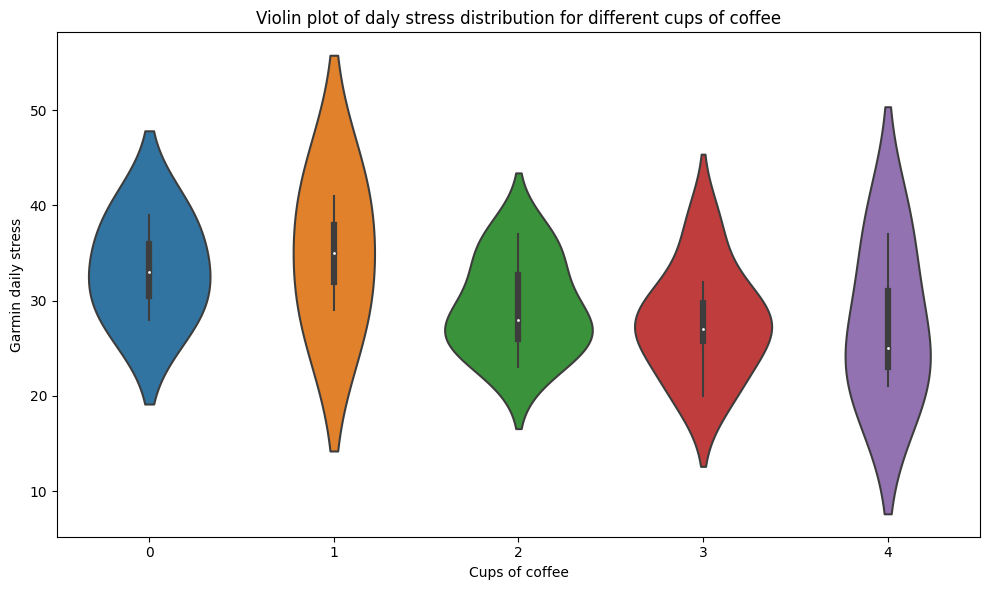

In [5]:

grouped_data = [group['value'].values for name, group in cups.history.groupby('option')]
fix, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x='option', y='value', data=cups.history, ax=ax)
ax.set_title('Violin plot of daly stress distribution for different cups of coffee')
ax.set_xlabel('Cups of coffee')
ax.set_ylabel('Garmin daily stress')
plt.tight_layout()
plt.show()

# Какой выход из МЦК утром?
* Садиться в ту дверь, которая кажется ближе к выходу
* считать от выхода на платформу до выхода из крутящихся дверей офиса


In [6]:
morning_exit = HandsTable(options_list=["мцк","мцд"], minimize=True)
# 3 мцк
# 6 мцд
morning_exit.update_hands("мцк", '0:08:03.7') # вторник 19 ноября
morning_exit.update_hands("мцд", '0:08:40') # среда 20 ноября
morning_exit.update_hands("мцк", '0:09:23.4') # mon 25 ноября
morning_exit.update_hands("мцд", '0:07:46.5') # вторник 26 ноября
morning_exit.update_hands("мцд", '0:07:27.9') # среда 27 ноября
morning_exit.update_hands("мцк", '0:09:11') # пятница 29 ноября
morning_exit.update_hands("мцд", '0:08:17.6') # понедельник 2 декабря
morning_exit.update_hands("мцд", '0:08:28.4') # вторник 3 декабря
morning_exit.update_hands("мцд", '0:08:28.4') # wed 4 dec
morning_exit.update_hands("мцд", '0:07:26') # th 5 dec
morning_exit.update_hands("мцд", '0:08:46.4') # fr 6 dec
morning_exit.update_hands("мцд", '0:08:51.5') # mon 9 dec
morning_exit.update_hands("мцд", '0:07:54.6') # th 12 dec
morning_exit.update_hands("мцд", '0:08:05.6') # fr 13 dec
morning_exit.update_hands("мцд", '0:08:37') # пн 16 dec
morning_exit.update_hands("мцд", '0:07:38.9') # tue 17 dec
morning_exit.update_hands("мцк", '0:08:59.2') # wed 18 dec
morning_exit.update_hands("мцд", '0:07:27.7') # th 19 dec
morning_exit.update_hands("мцд", '0:07:56.5') # fr 20 dec
morning_exit.update_hands("мцд", '0:07:26.32') # mon 23 dec
morning_exit.update_hands("мцд", '0:09:09.3') # tue 24 dec
morning_exit.update_hands("мцд", '0:07:53.2') # wed 25 dec
morning_exit.update_hands("мцд", '0:07:32.9') # thr 26 dec
morning_exit.update_hands("мцд", '0:07:06.4') # thr 09 jan 2025
morning_exit.update_hands("мцд", '0:08:12.6') # fr 10 jan 2025
morning_exit.update_hands("мцд", '0:07:39.3') # mon 13 jan 2025
morning_exit.update_hands("мцд", '0:07:54.4') # tue 14 jan 2025
morning_exit.update_hands("мцд", '0:07:47.1') # wed 15 jan 2025
morning_exit.update_hands("мцд", '0:08:24.0') # thr 16 jan 2025
morning_exit.update_hands("мцд", '0:07:15.4') # fr 17 jan 2025
morning_exit.update_hands("мцд", '0:08:04.1') # mon 20 jan 2025
morning_exit.update_hands("мцд", '0:07:52.4') # tue 21 jan 2025

morning_exit.grade()

,name,mu,Te,alpha,beta,tau,theta,SD,var95
1,мцд,8.006202,28.0,14.5,4.199769,3.692848,7.988697,0.520378,9.008620
0,мцк,8.905417,4.0,2.5,1.015287,1.400211,8.810752,0.845091,10.467099


In [7]:
fig = px.violin(morning_exit.history, y="value", x="option", box=True, points="all",
          hover_data=cups.history.columns)
fig.show()

# Какой вход в МЦК вечером?
* Садиться в ту дверь, которая кажется ближе к выходу
* считать от выхода из крутящихся дверей до посадки в поезд


In [8]:
evening_entrance = HandsTable(options_list=["мцк","мцд"], minimize=True)
# 3 мцк
# 6 мцд
evening_entrance.update_hands("мцд", '0:08:03.7') # четверг 21 ноября
evening_entrance.update_hands("мцк", '0:11:14') # четверг 28 ноября
evening_entrance.update_hands("мцд", '0:15:47.8') # понедельник 2 декабря
evening_entrance.update_hands("мцк", '0:11:03') # tue 3 dec
evening_entrance.update_hands("мцк", '0:14:29.3') # wed 4 dec
evening_entrance.update_hands("мцк", '0:12:05') # fr 06 dec
evening_entrance.update_hands("мцк", '0:13:53') # mon 09 dec
evening_entrance.update_hands("мцд", '0:10:14') # fr 13 декабря
evening_entrance.update_hands("мцк", '0:09:31.7') # tue 17 dec
evening_entrance.update_hands("мцк", '0:08:33') # wed 18 dec
evening_entrance.update_hands("мцд", '0:09:51.9') # th 19 dec
evening_entrance.update_hands("мцд", '0:09:16.1') # mon 23 dec
evening_entrance.update_hands("мцд", '0:09:31.7') # tue 24 dec
evening_entrance.update_hands("мцк", '0:08:19.6') # wed 18 dec
evening_entrance.update_hands("мцд", '0:09:18.6') # th 9 jan
evening_entrance.update_hands("мцк", '0:08:11.9') # fr 10 jan
evening_entrance.update_hands("мцд", '0:10:50') # mon 13 jan
evening_entrance.update_hands("мцд", '0:11:15') # tue 14 jan
evening_entrance.update_hands("мцк", '0:12:08') # wed 15 jan
evening_entrance.update_hands("мцк", '0:10:13') # tue 20 jan

evening_entrance.grade()

,name,mu,Te,alpha,beta,tau,theta,SD,var95
1,мцд,10.460741,9.0,5.0,20.005731,0.171252,10.434815,2.416476,15.171022
0,мцк,10.881061,11.0,6.0,23.809715,0.166460,10.657716,2.451010,15.461608


In [9]:
fig = px.violin(evening_entrance.history, y="value", x="option", box=True, points="all",
          hover_data=cups.history.columns)
fig.show()